In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

target: str
df: pd.DataFrame
modes: list[str]
pad: str

X: pd.DataFrame
X_temp: pd.DataFrame
X_test: pd.DataFrame
X_train: pd.DataFrame
X_val: pd.DataFrame

y: pd.Series
y_temp: pd.Series
y_test: pd.Series
y_train: pd.Series
y_val: pd.Series

target = 'Win'
modes = ['ARAM', 'CHERRY', 'CLASSIC', 'SWIFTPLAY', 'ULTBOOK']
pad = ' '

In [87]:
from numpy import sqrt


def train_and_evaluate_models() -> None:
    """
        Train Regresja Liniowa, kNN, and Drzewo Decyzyjne models.
        Tune hyperparameters on validation set.
        Evaluate all models on test set using accuracy, precision, recall, F1-score.
        
        Returns:
            results: dict with test metrics for each model
            trained_models: dict with trained model objects
    """

    scaler: StandardScaler
    X_train_scaled: pd.DataFrame
    X_val_scaled: pd.DataFrame
    X_test_scaled: pd.DataFrame
    lr_candidates: list[float]
    knn_candidates: list[int]
    dt_candidates: list[None | int]
    best_models: dict[str, Any]
    best_f1: float
    measures: pd.DataFrame

    measures = pd.DataFrame(
        np.empty((5,15)),
        index=['ARAM', 'CHERRY', 'CLASSIC', 'SWIFTPLAY', 'ULTBOOK'],
        columns=[
            np.array(['Regresja Liniowa']*5+['kNN']*5+['Drzewo Decyzyjne']*5),
            np.array(['Najlepszy hiperparametr', 'Dokładność', 'Precyzja', 'Pełność', 'F-miara']*3)
        ]
    )
    measures[:] = np.nan
    
    for mode in modes:
        df = pd.read_csv(f'../data/clean/num_{mode}.csv')
        X = df.drop(columns=target)
        y = df[target]

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y,
            test_size=0.10,
            random_state=42,
            stratify=y 
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=2/9,
            random_state=42,
            stratify=y_temp
        )
        # ====== 1. Scale features for LR and kNN ======
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)
        X_test_scaled  = scaler.transform(X_test)
        
        # ====== 2. Define models & candidate hyperparameters ======
        # Regresja Liniowa: regularization strength
        lr_candidates = [0.01, 0.1, 1, 10]
        # kNN: number of neighbors
        knn_candidates = [5, 10, 20, 50]
        # Drzewo Decyzyjne: max depth
        dt_candidates = [None, 5, 10, 20]
        
        best_models = {}
        hyperparameters = {}
        
        # ---------------- Regresja Liniowa ----------------
        best_f1 = -1
        for C in lr_candidates:
            lr = LogisticRegression(C=C, solver='liblinear', random_state=42)
            lr.fit(X_train_scaled, y_train)
            y_val_pred = lr.predict(X_val_scaled)
            f1 = f1_score(y_val, y_val_pred)
            if f1 > best_f1:
                best_f1 = f1
                hyperparameters['Regresja Liniowa'] = C
                best_models['Regresja Liniowa'] = lr
        
        # ---------------- kNN ----------------
        best_f1 = -1
        for k in knn_candidates:
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
            if k > len(X_train_scaled): continue
            knn.fit(X_train_scaled, y_train)
            y_val_pred = knn.predict(X_val_scaled)
            f1 = f1_score(y_val, y_val_pred)
            if f1 > best_f1:
                best_f1 = f1
                hyperparameters['kNN'] = k
                best_models['kNN'] = knn
        
        # ---------------- Drzewo Decyzyjne ----------------
        best_f1 = -1
        for depth in dt_candidates:
            dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
            dt.fit(X_train, y_train)  # no scaling needed
            y_val_pred = dt.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            if f1 > best_f1:
                best_f1 = f1
                hyperparameters['Drzewo Decyzyjne'] = depth
                best_models['Drzewo Decyzyjne'] = dt
        
        # ====== 3. Evaluate best models on test set ======
        for name in best_models:
            if name in ['Regresja Liniowa', 'kNN']:
                X_t = X_test_scaled
            else:
                X_t = X_test
            
            y_pred = best_models[name].predict(X_t)
            probs = best_models[name].predict_proba(X_t)
            # pred_classes = best_models[name].predict(X_t)
            confidence = np.max(probs, axis=1)

            measures.loc[mode, (name, 'Najlepszy hiperparametr')] = hyperparameters[name]
            for measure_name, measure in zip(['Dokładność', 'Precyzja', 'Pełność', 'F-miara'], [accuracy_score, precision_score, recall_score, f1_score]):
                measures.at[mode, (name, measure_name)] = measure(y_test, y_pred)
            
            # print(f'\t{name}')
            # print(f'\t\tBest hyperparameter: {hyperparameters[name]:{".4f" if hyperparameters[name] != None else ""}}')
            # print()
            # print(f'\t\t{"Accuracy":>10}: {accuracy_score(y_test, y_pred): .2%}')
            # print(f'\t\t{"Precision":>10}: {precision_score(y_test, y_pred): .2%}')
            # print(f'\t\t{"Recall":>10}: {recall_score(y_test, y_pred): .2%}')
            # print(f'\t\t{"F1":>10}: {f1_score(y_test, y_pred): .2%}')
            
            plt.hist(confidence, bins=20)
            plt.title(f'{name} Pewność predykcji - {mode}')
            plt.xlabel('Pewność')
            plt.ylabel('# prób')
            plt.show()
        
    display(measures)


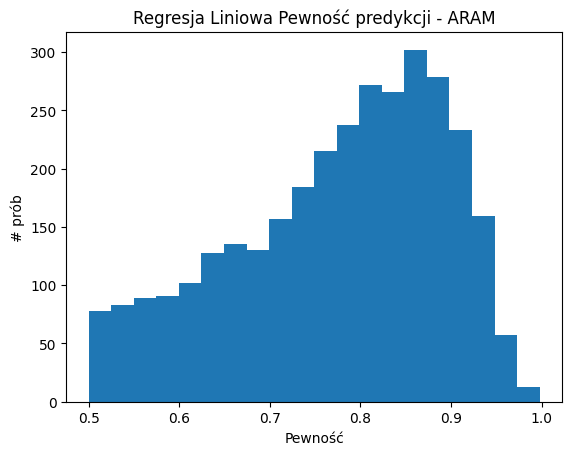

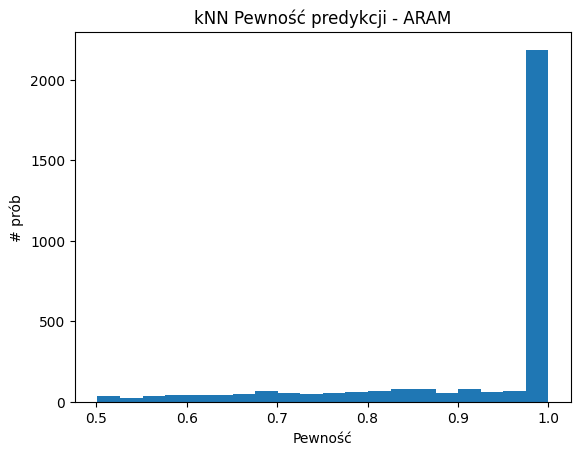

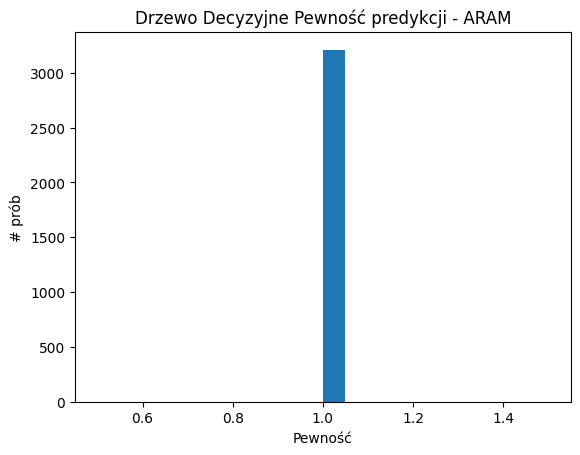

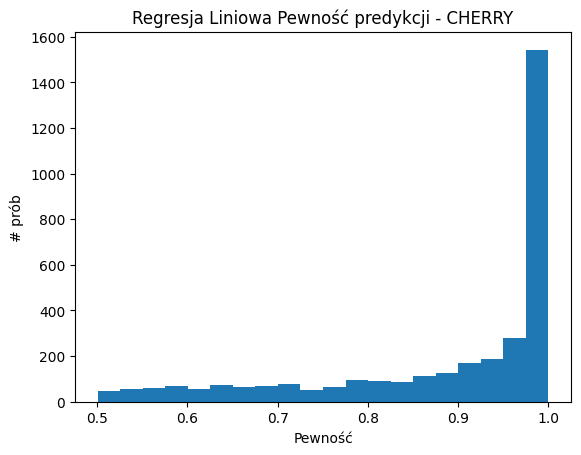

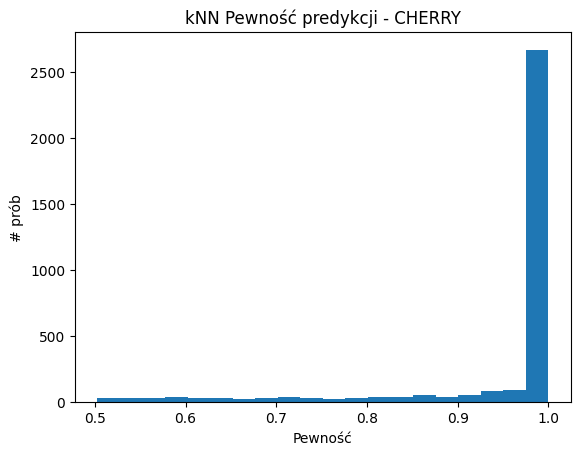

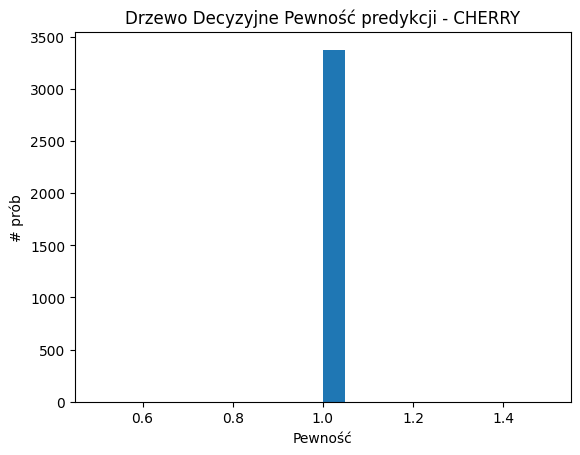

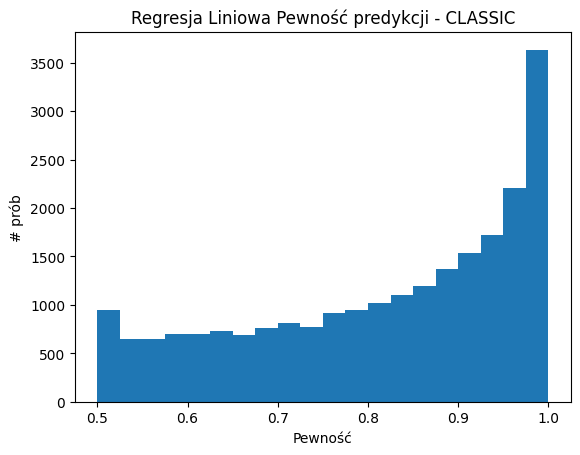

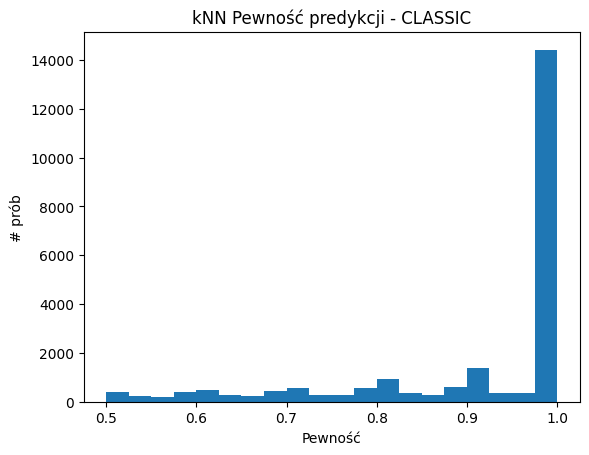

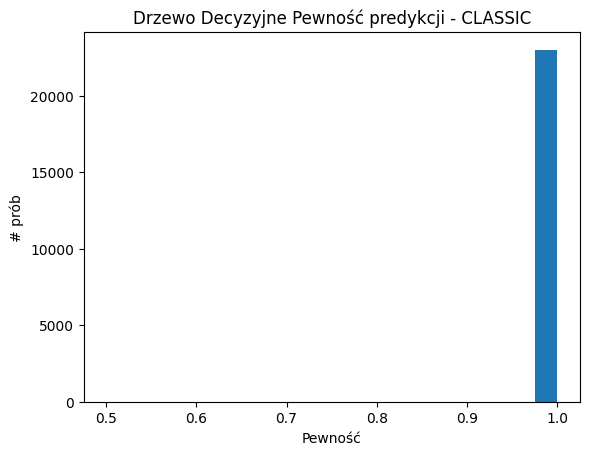

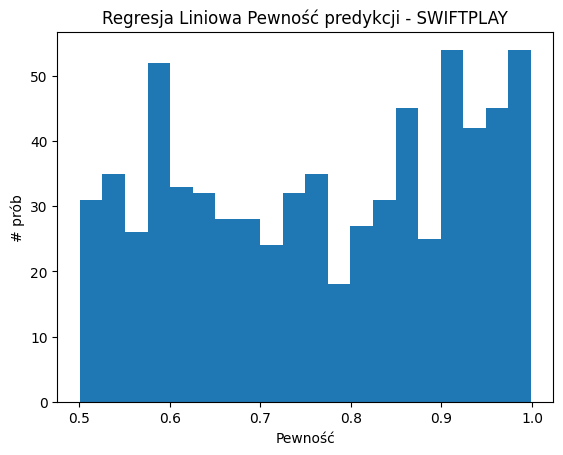

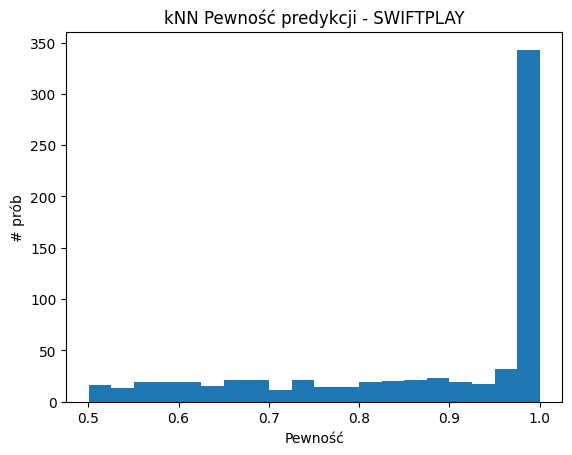

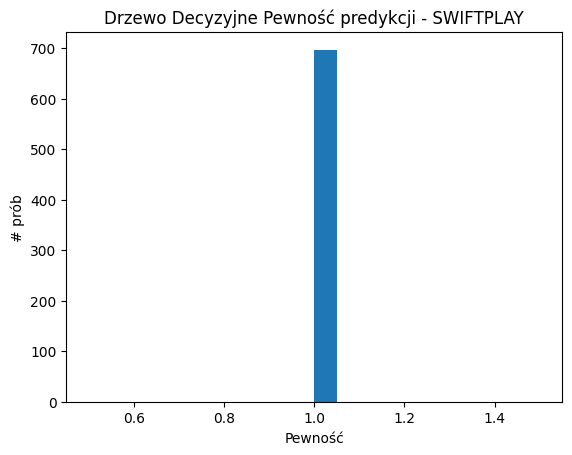

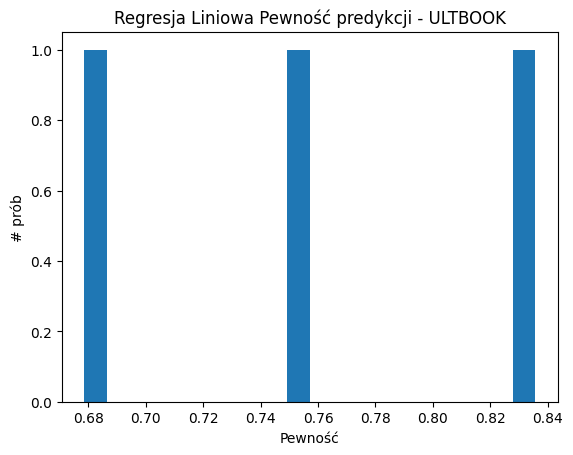

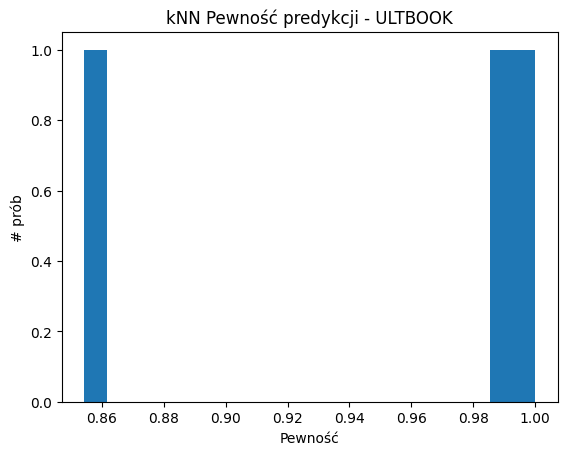

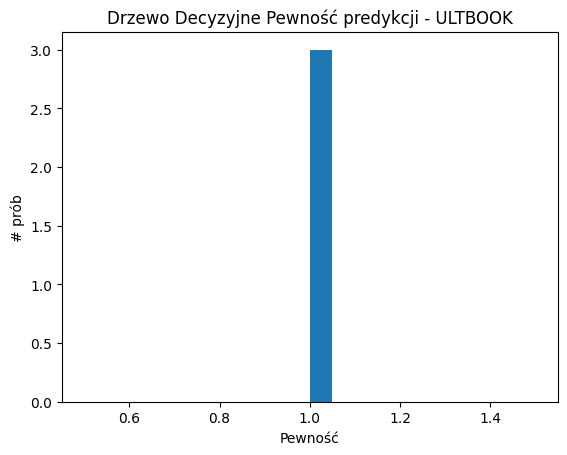

Regresja Liniowa                                           \
          Najlepszy hiperparametr Dokładność  Precyzja   Pełność   F-miara   
ARAM                         1.00   0.770717  0.792730  0.751511  0.771570   
CHERRY                       0.10   0.886586  0.896165  0.880070  0.888044   
CLASSIC                      0.01   0.833312  0.850985  0.810902  0.830460   
SWIFTPLAY                   10.00   0.741750  0.783708  0.730366  0.756098   
ULTBOOK                      0.10   1.000000  1.000000  1.000000  1.000000   

                              kNN                                           \
          Najlepszy hiperparametr Dokładność  Precyzja   Pełność   F-miara   
ARAM                         50.0   0.926791  0.929220  0.928658  0.928939   
CHERRY                       50.0   0.952621  0.955763  0.951333  0.953542   
CLASSIC                      10.0   0.911605  0.916116  0.907517  0.911797   
SWIFTPLAY                    20.0   0.870875  0.884211  0.879581  0.881890   
ULTBOOK                       5.0   1.000000  1.000000  1.000000  1.000000   

                 Drzewo Decyzyjne                                           
          Najlepszy hiperparametr Dokładność  Precyzja   Pełność   F-miara  
ARAM                          NaN   0.890343  0.898409  0.887545  0.892944  
CHERRY                        NaN   0.936926  0.931546  0.946118  0.938776  
CLASSIC                       NaN   0.899380  0.900517  0.899509  0.900013  
SWIFTPLAY                     NaN   0.853659  0.851759  0.887435  0.869231  
ULTBOOK                       NaN   1.000000  1.000000  1.000000  1.000000

In [88]:
# for mode in modes:
#     df = pd.read_csv(f'../data/clean/num_{mode}.csv')
#     X = df.drop(columns=target)
#     y = df[target]

#     X_temp, X_test, y_temp, y_test = train_test_split(
#         X, y,
#         test_size=0.10,
#         random_state=42,
#         stratify=y 
#     )
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_temp, y_temp,
#         test_size=2/9,
#         random_state=42,
#         stratify=y_temp
#     )
    
#     print(mode)
train_and_evaluate_models()